# Classifying BBC Full Text with DistilBERT



This Notebook will show you how to fine-tune DistilBERT for *document* classification tasks using the [BBC Full Text](https://www.kaggle.com/shivamkushwaha/bbc-full-text-document-classification) dataset as an example.

# Contents

See "Table of contents" in the sidebar to the left.

# Part I - Setup & Dataset Prep
-------------------------------

## 1. Setup


### 1.1. Using Colab GPU for Training



Google Colab offers free GPUs and TPUs! Since we'll be training a large neural network it's best to take advantage of this (in this case we'll attach a GPU), otherwise training will take a very long time.

A GPU can be added by going to the menu and selecting:

`Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 (GPU)`

Then run the following cell to confirm that the GPU is detected.

In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [3]:
!nvidia-smi

Fri Jan 15 18:07:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    34W /  70W |    227MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 1.2. Installing the Hugging Face Library



Next, let's install the [transformers](https://github.com/huggingface/transformers) package from Hugging Face which will give us a pytorch interface for working with DistilBERT. 

In [4]:
!pip install -qq transformers

     |████████████████████████████████| 1.8MB 7.4MB/s 
     |████████████████████████████████| 890kB 33.4MB/s 
     |████████████████████████████████| 2.9MB 49.8MB/s 


## 2. Retrieve & Inspect Dataset




This notebook will download and tokenize a text dataset.

We'll use torch.Dataset to build our dataset.

### 2.1. Download
--------------------------------------
Download the text.

First of all, you have to upload your kaggle credential. Just check [this link](https://www.kaggle.com/docs/api) if you don't know what is it.

In [5]:
!pip install -qq kaggle
!pip install -qq --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 5.1MB/s 


In [6]:
!mkdir /root/.kaggle

In [7]:
!mv kaggle.json /root/.kaggle/

In [8]:
!chmod 600 /root/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d shivamkushwaha/bbc-full-text-document-classification

 89% 5.00M/5.59M [00:00<00:00, 51.6MB/s]
100% 5.59M/5.59M [00:00<00:00, 56.7MB/s]


In [10]:
!unzip -qq bbc-full-text-document-classification.zip

### 2.2. Parse & Inspect
-------------------


Let's import some modules for visualization, building our dataset and building model for classification

In [4]:
from typing import List, Mapping, Tuple

In [5]:
import logging
import os
from pathlib import Path

In [6]:
import pandas as pd
import numpy as np
import re
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
from tqdm import tqdm

In [10]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

We have to predict label for each document in dataset. Let's store all possible labels in variable ```set_of_labels```

In [11]:
text_dir = Path('bbc')
set_of_labels = [label for label in os.listdir(text_dir) if os.path.isdir(text_dir / label)]

Next, we are going to store each text and corresponding label in DataFrame

In [12]:
texts = []
labels = []

for label in tqdm(set_of_labels):
    files_path = text_dir / label
    for file_name in os.listdir(files_path):
        if not file_name.endswith('.txt'):
            continue
        with open(files_path / file_name, 'r', encoding="utf8", errors='ignore') as f:
            text = f.read()
            texts.append(text)
            labels.append(label)

100%|██████████| 5/5 [00:00<00:00, 67.47it/s]


In [13]:
TEXT_COLUMN = 'text'
LABEL_COLUMN = 'label'

data_df = pd.DataFrame({
    TEXT_COLUMN: texts,
    LABEL_COLUMN: labels
})
data_df.shape

(2225, 2)

Let's take a look at the first few rows of the table just to see what's in there.

In [14]:
data_df.head()

,text,label
0,Labour MP praises Tory campaign\n\nThe Conserv...,politics
1,Clarke faces ID cards rebellion\n\nCharles Cla...,politics
2,Straw to attend Auschwitz service\n\nForeign S...,politics
3,Boothroyd calls for Lords speaker\n\nBetty Boo...,politics
4,TV debate urged for party chiefs\n\nBroadcaste...,politics


Let's take a look at the distribution of our labels

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


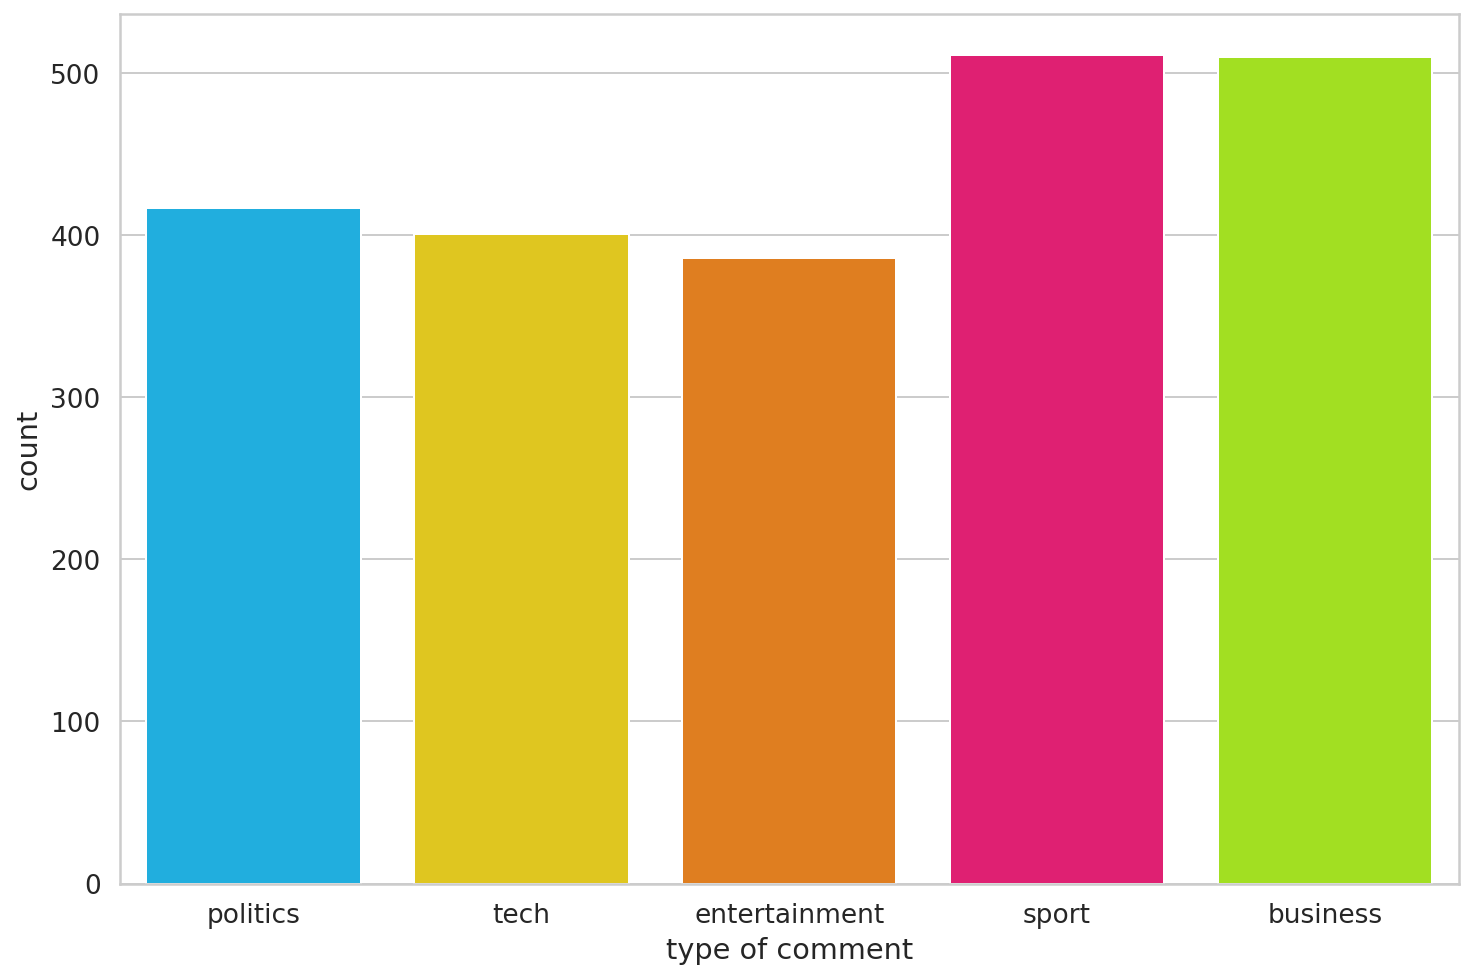

In [15]:
ax = sns.countplot(data_df.label)
plt.xlabel('type of comment');

Now, we are going to clean our texts (remove bad symbols, spaces and stopwords)

In [16]:
# some constants for text cleaning
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(nltk.corpus.stopwords.words('english'))

def text_cleaning(text: str) -> str:
    """
    Args:
        text (str): a string
    Returns:
        modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
#     text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [17]:
data_df.text = data_df.text.apply(text_cleaning)

Let's take a look at the first few rows of the table after text cleaning

In [18]:
data_df.head()

,text,label
0,labour mp praises tory campaignthe conservativ...,politics
1,clarke faces id cards rebellioncharles clarke ...,politics
2,straw attend auschwitz serviceforeign secretar...,politics
3,boothroyd calls lords speakerbetty boothroyd s...,politics
4,tv debate urged party chiefsbroadcasters fix d...,politics


Next, we should divide our dataset on train, validation and test

In [19]:
df_train, df_test = train_test_split(data_df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [20]:
df_train.shape, df_val.shape, df_test.shape

((2002, 2), (111, 2), (112, 2))

Let's define class of our Dataset

In [21]:
class TextClassificationDataset(Dataset):
    """
    Wrapper around Torch Dataset to perform text classification
    """

    def __init__(
        self,
        texts: List[str],
        labels: List[str] = None,
        label_dict: Mapping[str, int] = None,
        max_seq_length: int = 512,
        model_name: str = "distilbert-base-uncased",
    ):
        """
        Args:
            text_dir (str): a list with texts to classify or to train the
                classifier on
            labels (List[str]): a list with classification labels (optional)
            label_dict (dict): a dictionary mapping class names to class ids,
                to be passed to the validation data (optional)
            max_seq_length (int): maximal sequence length in tokens,
                texts will be stripped to this length
            model_name (str): transformer model name, needed to perform
                appropriate tokenization
        """

        self.texts = texts
        self.labels = labels
        self.label_dict = label_dict
        self.max_seq_length = max_seq_length

        if self.label_dict is None and labels is not None:
            # {'class1': 0, 'class2': 1, 'class3': 2, ...}
            # using this instead of `sklearn.preprocessing.LabelEncoder`
            # no easily handle unknown target values
            self.label_dict = dict(
                zip(sorted(set(labels)), range(len(set(labels))))
            )

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        # suppresses tokenizer warnings
        logging.getLogger("transformers.tokenization_utils").setLevel(
            logging.FATAL
        )

    def __len__(self) -> int:
        """
        Returns:
            int: length of the dataset
        """
        return len(self.texts)

    def __getitem__(self, index: int) -> Mapping[str, torch.Tensor]:
        """Gets element of the dataset
        Args:
            index (int): index of the element in the dataset
        Returns:
            Single element by index
        """

        # encoding the text
        x = self.texts[index]

        # a dictionary with `input_ids` and `attention_mask` as keys
        output_dict = self.tokenizer.encode_plus(
            x,
            add_special_tokens=True,
            padding="max_length",
            max_length=self.max_seq_length,
            return_tensors="pt",
            truncation=True,
            return_attention_mask=True,
        )

        output_dict["input_ids"] = output_dict["input_ids"].flatten()
        output_dict["attention_mask"] = output_dict["attention_mask"].flatten()

        # encoding target
        if self.labels is not None:
            y = self.labels[index]
            y_encoded = (
                torch.Tensor([self.label_dict.get(y, -1)]).long().squeeze(0)
            )
            output_dict["targets"] = y_encoded

        return output_dict


## 3. BERT Input Length Limitation

BERT has a maximum input length of 512 tokens. In this section, we'll look at how this limitation affects us in practice, and some possible approaches for addressing it.

### 3.1. Examples of 512 Tokens

Let's look at an example comment which gets split into more than 512 tokens, so that we can get a sense for how much text fits within this limit.

First we'll need to load the DistilBERT tokenizer.

In [22]:
MODEL_NAME = 'distilbert-base-uncased'

In [23]:
# Load the DistilBERT tokenizer.

print('Loading DistilBERT tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Loading DistilBERT tokenizer...


### 3.2. Strategies for Longer Text

Key points:
* There's no *obvious* solution, but we'll cover a number of ideas to try.
* Looking at the statistics of your dataset should help when choosing your strategy. We'll do this in section 3.3.

There was a [paper published](https://arxiv.org/pdf/1905.05583.pdf) recently that investigated this problem and experimented with a few approaches.  Check out section 5.3. specifically. 

![BERT Text Classification Paper](http://www.mccormickml.com/assets/BERT/text_classification_paper.png)




**Truncation**

The simplest approach is just to drop some of the tokens, and hope that the remaining text is enough to perform the task well.

You could drop tokens:
* From the beginning of the text.
* At the end of the text.
* In the middle of the text.

In the above paper, their experiments on the IMDb movie review dataset showed that keeping the first 128 tokens and the last 382 tokens performed best. (Note: This adds up to 510 tokens, leaving room for the special `[CLS]` and `[SEP]` tokens that we have to append to the beginning and the end of the text, respectively). 

Perhaps this is because, when writing something like a movie review, we tend to put our high-level points in the introduction and conclusion?



**Chunking**

Another approach attempted by the authors (and also proposed in [this thread](https://github.com/google-research/bert/issues/650) in the BERT GitHub repo) would be to divide the text into 512-token chunks and generate embeddings for these chunks separately. 

The authors of the paper combined the embeddings for the different chunks before performing the final classification. They tried several "pooling" strategies, such as averaging the embeddings together. None of these approaches outperformed the simple truncation approach, however.

In the GitHub discussion above, the user suggested instead classifying the chunks separately and then averaging together the predictions ("chunking" approaches could be computationly expensive when dealing with lengthy documents).


### 3.3. Comment Length Distribution

To decide on a truncation strategy for this dataset, let's first look at the distribution of comment lenghts.

To do this, our first step is to tokenize all of the comments in the training set.

**Tokenize All Comments**

The `tokenizer.encode` function combines multiple steps for us:
1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.

In order to explore the distribution of comment lengths, we will not perform any truncation here. Unfortunately, this results in the tokenizer spitting out a warning for every comment that's longer than 512 tokens. We'll just have to ignore those for now!

In [24]:
import numpy as np

# Record the length of each sequence (after truncating to 512).
lengths = []

print('Tokenizing comments...')

# For every sentence...
for sen in df_train.text:
    
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sen,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        #max_length = 512,          # Truncate all sentences.                        
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Record the truncated length.
    lengths.append(len(encoded_sent))

print('DONE.')

Token indices sequence length is longer than the specified maximum sequence length for this model (605 > 512). Running this sequence through the model will result in indexing errors


Tokenizing comments...
DONE.


Let's grab some quick statistics--what are the min, max and median comment lenghts?

In [25]:
print('   Min length: {:,} tokens'.format(min(lengths)))
print('   Max length: {:,} tokens'.format(max(lengths)))
print('Median length: {:,} tokens'.format(np.median(lengths)))

   Min length: 59 tokens
   Max length: 2,594 tokens
Median length: 236.0 tokens


To further analyze it, let's plot the distribution. To keep the scale of the x-axis reasonable, *we'll clip the lengths to 512.*


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '# of Text')

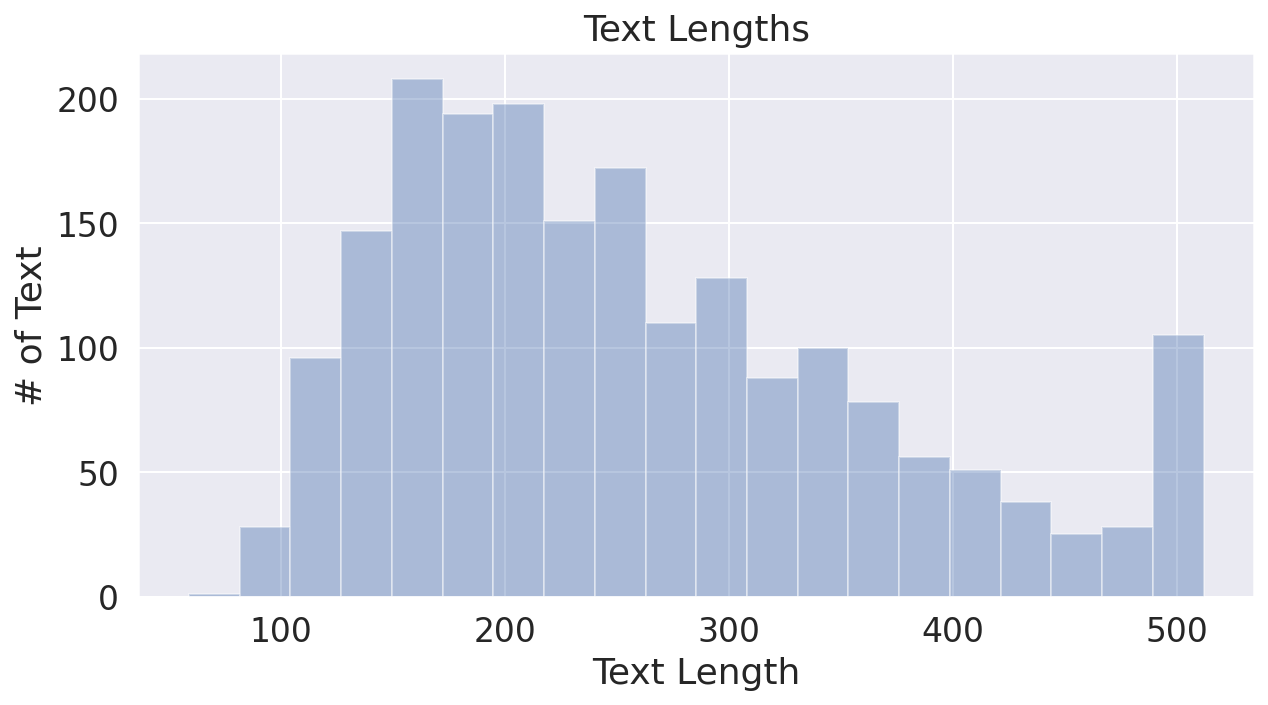

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)

# Truncate any comment lengths greater than 512.
lengths = [min(l, 512) for l in lengths]

# Plot the distribution of comment lengths.
sns.distplot(lengths, kde=False, rug=False)

# Alternatively, you might try using a log scale on the x-axis, but this is 
# tricky. See here for one approach:
# https://stackoverflow.com/questions/47850202/plotting-a-histogram-on-a-log-scale-with-matplotlib?rq=1
#plt.xscale('log')

plt.title('Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('# of Text')


Clearly most comments are "short", and there's a long tail of longer comments. 

Just how many of the examples run into the 512-token limit?

In [27]:
# Count the number of sentences that had to be truncated to 512 tokens.
num_truncated = lengths.count(512)

# Compare this to the total number of training sentences.
num_sentences = len(lengths)
prcnt = float(num_truncated) / float(num_sentences)

print('{:,} of {:,} sentences ({:.1%}) in the training set are longer than 512 tokens.'.format(num_truncated, num_sentences, prcnt))

89 of 2,002 sentences (4.4%) in the training set are longer than 512 tokens.


Now, let's create our DataLoaders:

Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.



In [28]:
MAX_SEQ_LEN = 400
BATCH_SIZE = 8

In [29]:
train_dataset = TextClassificationDataset(
    texts=df_train[TEXT_COLUMN].values.tolist(),
    labels=df_train[LABEL_COLUMN].values,
    max_seq_length=MAX_SEQ_LEN,
    model_name=MODEL_NAME,
)

valid_dataset = TextClassificationDataset(
    texts=df_val[TEXT_COLUMN].values.tolist(),
    labels=df_val[LABEL_COLUMN].values,
    max_seq_length=MAX_SEQ_LEN,
    model_name=MODEL_NAME,
)

test_dataset = TextClassificationDataset(
    texts=df_test[TEXT_COLUMN].values.tolist(),
    labels=df_test[LABEL_COLUMN].values,
    max_seq_length=MAX_SEQ_LEN,
    model_name=MODEL_NAME,
)

In [30]:
train_data_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

val_data_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

test_data_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Let's have a look at an example batch from our training data loader:

In [31]:
mini_batch_data = next(iter(train_data_loader))
mini_batch_data.keys()

dict_keys(['input_ids', 'attention_mask', 'targets'])

In [32]:
print(mini_batch_data['input_ids'].shape)
print(mini_batch_data['attention_mask'].shape)
print(mini_batch_data['targets'].shape)

torch.Size([8, 400])
torch.Size([8, 400])
torch.Size([8])


# Part II - BERT Fine-Tuning

## 4. Train Our Classification Model

Now that our input data is properly formatted, it's time to fine tune the BERT model. 

### 4.1. BertForSequenceClassification

For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task. 

Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.  

Here is the current list of classes provided for fine-tuning:
* BertModel
* BertForPreTraining
* BertForMaskedLM
* BertForNextSentencePrediction
* **BertForSequenceClassification** - The one we'll use.
* BertForTokenClassification
* BertForQuestionAnswering

The documentation for these can be found under [here](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html).



We'll be using [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification). This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task. 


OK, let's load BERT! There are a few different pre-trained BERT models available. "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

The documentation for `from_pretrained` can be found [here](https://huggingface.co/transformers/v2.2.0/main_classes/model.html#transformers.PreTrainedModel.from_pretrained), with the additional parameters defined [here](https://huggingface.co/transformers/v2.2.0/main_classes/configuration.html#transformers.PretrainedConfig).

In [33]:
import torch.nn as nn
from transformers import AutoConfig, AutoModel, AdamW, get_linear_schedule_with_warmup

In [34]:
import torch.nn.functional as F

In [35]:
class BertForSequenceClassification(nn.Module):
    """
    Simplified version of the same class by HuggingFace.
    See transformers/modeling_distilbert.py in the transformers repository.
    """

    def __init__(
        self,
        pretrained_model_name: str,
        num_classes: int = None,
        dropout: float = 0.3
    ):
        """
        Args:
            pretrained_model_name (str): HuggingFace model name.
                See transformers/modeling_auto.py
            num_classes (int): the number of class labels
                in the classification task
        """
        super().__init__()

        config = AutoConfig.from_pretrained(
            pretrained_model_name, num_labels=num_classes
        )

        self.model = AutoModel.from_pretrained(pretrained_model_name, config=config)
        self.classifier = nn.Linear(config.hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask=None, head_mask=None):
        """Compute class probabilities for the input sequence.

        Args:
            features (torch.Tensor): ids of each token,
                size ([bs, seq_length]
            attention_mask (torch.Tensor): binary tensor, used to select
                tokens which are used to compute attention scores
                in the self-attention heads, size [bs, seq_length]
            head_mask (torch.Tensor): 1.0 in head_mask indicates that
                we keep the head, size: [num_heads]
                or [num_hidden_layers x num_heads]
        Returns:
            PyTorch Tensor with predicted class scores
        """
        assert attention_mask is not None, "attention mask is none"

        # taking BERTModel output
        # see https://huggingface.co/transformers/model_doc/bert.html#transformers.BertModel
        bert_output = self.model(
            input_ids=input_ids, attention_mask=attention_mask, head_mask=head_mask
        )
        # we only need the hidden state here and don't need
        # transformer output, so index 0
        seq_output = bert_output[0]  # (bs, seq_len, dim)
        # mean pooling, i.e. getting average representation of all tokens
        pooled_output = seq_output.mean(axis=1)  # (bs, dim)
        pooled_output = self.dropout(pooled_output)  # (bs, dim)
        scores = self.classifier(pooled_output)  # (bs, num_classes)

        return scores

In [36]:
# Number of training epochs (authors recommend between 2 and 4)
N_EPOCH = 4

In [37]:
model = BertForSequenceClassification(
    pretrained_model_name=MODEL_NAME,
    num_classes=data_df.label.unique().shape[0],
    dropout=0.3
).to(device)

### 4.2. Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values:
- Batch size: 16, 32  (We chose 32 when creating our DataLoaders).
- Learning rate (Adam): 5e-5, 3e-5, 2e-5  (We'll use 2e-5).
- Number of epochs: 2, 3, 4  (We'll use 4).

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [38]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"

# args.learning_rate - default is 5e-5, our notebook had 2e-5
# args.adam_epsilon  - default is 1e-8.
optimizer = AdamW(model.parameters(), lr=2e-5)

In [39]:
steps_per_epoch=len(df_train) // BATCH_SIZE
warmup_step = steps_per_epoch // 3
total_steps = steps_per_epoch * N_EPOCH - warmup_step

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            warmup_step,
                                            total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

In [40]:
prediction = model(input_ids=mini_batch_data['input_ids'].to(device),
                   attention_mask=mini_batch_data['attention_mask'].to(device)
)

In [41]:
print(prediction.size())
prediction[:3]

torch.Size([8, 5])


tensor([[ 0.1288,  0.0381,  0.0826, -0.0860, -0.0771],
        [ 0.1192,  0.0973,  0.0717, -0.1026, -0.2015],
        [ 0.1321, -0.0647,  0.0087,  0.0014, -0.0986]], device='cuda:0',
       grad_fn=<SliceBackward>)

### 4.3. Training Loop

Let's continue with writing a helper function for training our model for one epoch:

In [42]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    
    losses = []
    correct_predictions = 0

    for d in data_loader:
        optimizer.zero_grad()
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask)
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
    return correct_predictions.double() / n_examples, np.mean(losses)

Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using [clip_gradnorm](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).

Let's write another one that helps us evaluate the model on a given data loader:

In [43]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask)
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop. We'll also store the training history:

In [44]:
from collections import defaultdict

In [45]:
%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(N_EPOCH):
    print(f'Epoch {epoch + 1}/{N_EPOCH}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn, 
        device, 
        len(df_val)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
Epoch 1/4
----------
Train loss 0.5526254760357459 accuracy 0.7927072927072927
Val   loss 0.0838229742616282 accuracy 0.9729729729729729

Epoch 2/4
----------
Train loss 0.07277143928797478 accuracy 0.9845154845154845
Val   loss 0.05475886759398106 accuracy 0.9819819819819819

Epoch 3/4
----------
Train loss 0.028613226439532975 accuracy 0.9925074925074925
Val   loss 0.07019650170695968 accuracy 0.9819819819819819

Epoch 4/4
----------
Train loss 0.013363426280591964 accuracy 0.997002997002997
Val   loss 0.05487784280558117 accuracy 0.9819819819819819



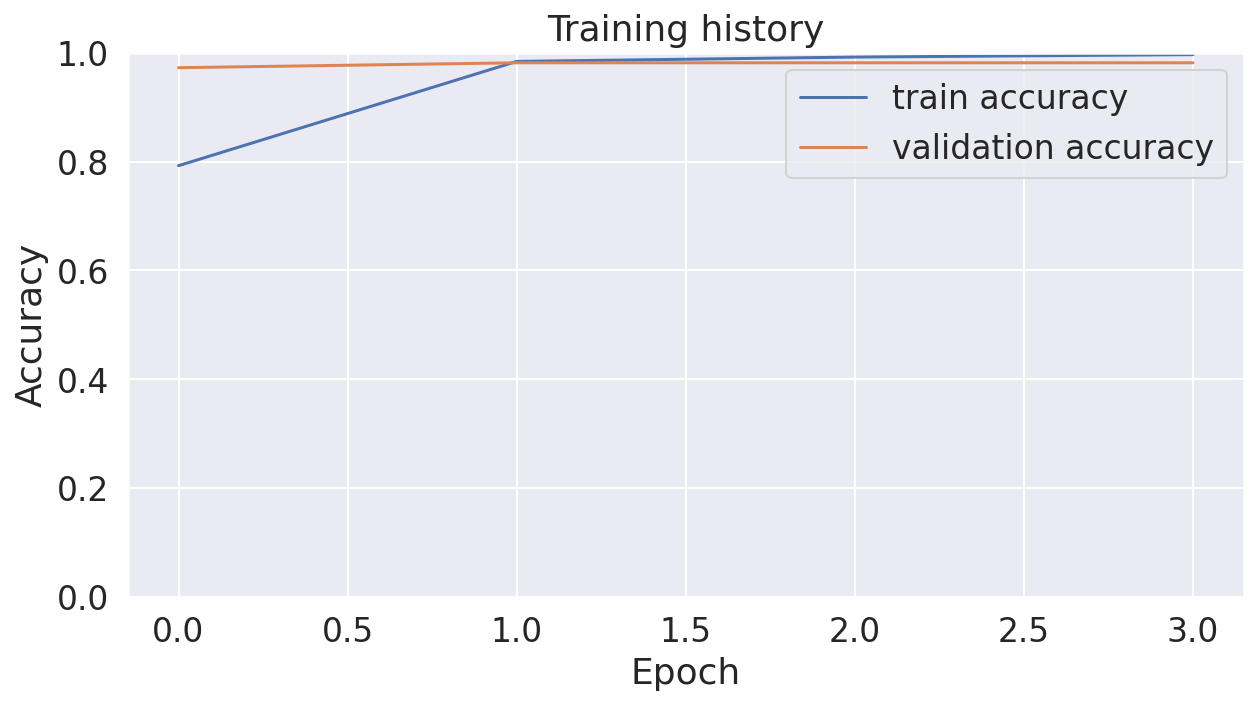

In [46]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

## Evaluation

We'll define a helper function to get the predictions from our model:

In [47]:
def get_predictions(model, data_loader,):
    model = model.eval()

    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return predictions, prediction_probs, real_values

In [48]:
from sklearn.metrics import confusion_matrix, classification_report

In [49]:
y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader,
)

Let's have a look at the classification report

In [50]:
print(classification_report(y_test, y_pred, target_names=set_of_labels))

               precision    recall  f1-score   support

     politics       0.95      1.00      0.98        20
         tech       1.00      1.00      1.00        20
entertainment       1.00      1.00      1.00        31
        sport       1.00      1.00      1.00        23
     business       1.00      0.94      0.97        18

     accuracy                           0.99       112
    macro avg       0.99      0.99      0.99       112
 weighted avg       0.99      0.99      0.99       112



We'll continue with the confusion matrix:

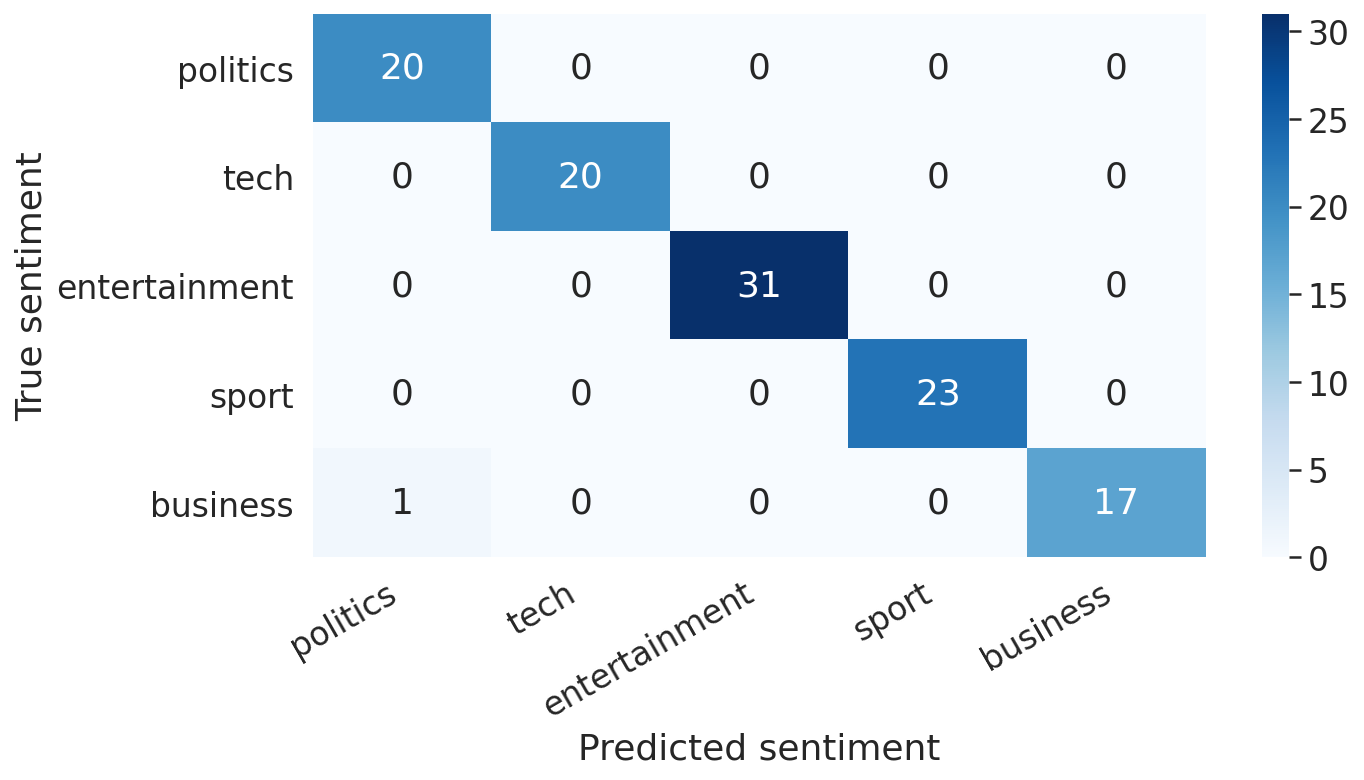

In [51]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=set_of_labels, columns=set_of_labels)
show_confusion_matrix(df_cm)